This worksheet is to create a basice neural network model.  

# Data Preprocessing

First I've imported all of fastai which includes pandas and numpy. Then I'll import some of the other functionality I'll need. Next I uploaded the train and test csv files as dataframes and then show their heads just to see what the columns contain. 

In [1]:
from fastai.imports import *

from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
#from sklearn.tree import DecisionTreeRegressor

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

I want to add new columns for the group and size subcomponents in PassengerId, two new columns to separate out the deck and the side of the Cabin, a new columnn for last name, and a new column to sum up all the spending for the RoomService, FoodCourt, ShoppingMall, Spa and VRDeck columns.

In [3]:
train['Group'] = train['PassengerId'].str[0:4]
train['Deck'] = train['Cabin'].str[0]
train['Side'] = train['Cabin'].str[4]
train['Side'] = train['Cabin'].str.strip().str[-1]
splitted = train['Name'].str.split()
train['LastName'] = splitted.str[-1]
train['Spend'] = train['RoomService'] + train['FoodCourt'] + train['ShoppingMall'] + train['Spa'] + train['VRDeck']

In [4]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Deck,Side,LastName,Spend
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,B,P,Ofracculy,0.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,F,S,Vines,736.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,A,S,Susent,10383.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,A,S,Susent,5176.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,F,S,Santantines,1091.0


I also want to do the same things on the test dataset

In [5]:
test['Group'] = test['PassengerId'].str[0:4]
test['Deck'] = test['Cabin'].str[0]
test['Side'] = test['Cabin'].str.strip().str[-1]
splitted = test['Name'].str.split()
test['LastName'] = splitted.str[-1]
test['Spend'] = test['RoomService'] + test['FoodCourt'] + test['ShoppingMall'] + test['Spa'] + test['VRDeck']

In [6]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Group,Deck,Side,LastName,Spend
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,0013,G,S,Carsoning,0.0
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,0018,F,S,Peckers,2832.0
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,0019,C,S,Unhearfus,0.0
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,0021,C,S,Caltilter,7418.0
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,0023,F,S,Harperez,645.0


In [7]:
len(test.index)

4277

It's interesting that most of the columns have between 179 and 217 missing data fields. Almost all the columns have missing data and the range is very tight. However out of 8693 rows this missing data amounts to only about 2% of the total rows. But the random forest model will need to multiply a coefficient by each value. This can't be done for the missing values. So I'll need to replace the missing values with a number. The easiest way to do this is to replace them with the mode of a column. The mode is the number that occurs most often in a set of values.

In [8]:
train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
Group             0
Deck            199
Side            199
LastName        200
Spend           908
dtype: int64

In [9]:
test.isna().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
Group             0
Deck            100
Side            100
LastName         94
Spend           455
dtype: int64

I want to do the easiest separation of continuous and categorical variables possible, so I'm using cont_cat_split. 

In [10]:
cont,cat = cont_cat_split(train)

We can see that now the continuous and categorical columns are identified. 

In [11]:
cont

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Spend']

In [12]:
cat

['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'VIP',
 'Name',
 'Transported',
 'Group',
 'Deck',
 'Side',
 'LastName']

In preparation for setting up the validation dataset I want to remove the target Transported column from the cat values, now that I've converted it to a number, and also identify it as the dependent variable. 

In [13]:
cat.remove('Transported')

In [14]:
cat

['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'VIP',
 'Name',
 'Group',
 'Deck',
 'Side',
 'LastName']

First I'll split train into the training and validation datasets. 

In [15]:
splits = RandomSplitter(valid_pct=0.2, seed=42)(range_of(train))

TabularPandas is the main dataloader for fastai for tabular data. Categorify changes the categorical values into numbers. FillMissing fills missing data with the mean of their columns. I tried to use the mode option instead, but I couldn't get it to work. For neural networks we need to normalize the data, so Normalize does that.

In [16]:
to_train = TabularPandas(train, procs=[Categorify, FillMissing, Normalize],
                   cat_names = cat,
                   cont_names = cont,
                   y_names='Transported',
                   y_block = CategoryBlock,
                   splits=splits)

This is to set up the dataloaders with a batch size of 64. 

In [17]:
dls = to_train.dataloaders(bs=64)

This is a simple neural network. I also tried a 3 level network, but it produced a worse score. 

In [18]:
learn = tabular_learner(dls, metrics=accuracy)

In [133]:
#learn = tabular_learner(dls, layers=[1000, 200, 15], metrics=accuracy)

I want to find the best learning rate, which turns out to be 10-3. 

SuggestedLRs(valley=0.0012022644514217973)

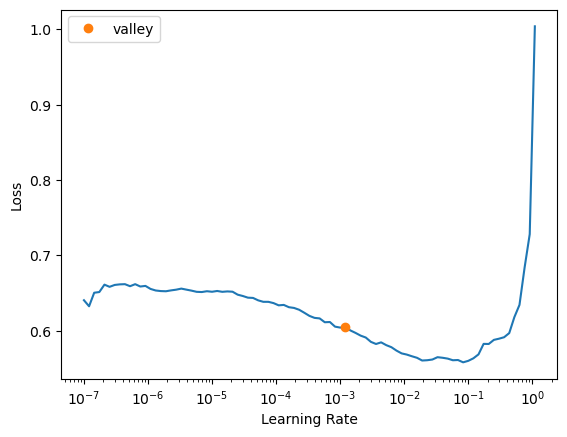

In [19]:
learn.lr_find()

Since this is a small dataset, I'll do 10 full epochs at the recommended learning rate. 

In [20]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.515478,0.485608,0.775029,00:08
1,0.278504,0.551424,0.745109,00:07
2,0.124088,0.561125,0.784810,00:07
3,0.048763,0.628892,0.795167,00:07
4,0.020827,0.707399,0.783659,00:07
5,0.011916,0.832073,0.788838,00:07
6,0.006739,0.802677,0.789413,00:07
7,0.002763,0.894267,0.787687,00:08
8,0.001083,0.908621,0.788262,00:11
9,0.000797,0.907756,0.787687,00:14


In [21]:
learn.show_results()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name,Group,Deck,Side,LastName,Age_na,RoomService_na,FoodCourt_na,ShoppingMall_na,Spa_na,VRDeck_na,Spend_na,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Spend,Transported,Transported_pred
0,35.0,3.0,1.0,4407.0,3.0,1.0,1781.0,24.0,6.0,1.0,542.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.865111,-0.327108,-0.284024,-0.280751,-0.267997,-0.263126,-0.514745,1.0,1.0
1,539.0,2.0,2.0,765.0,3.0,1.0,166.0,384.0,3.0,1.0,1463.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.682779,-0.327108,-0.284024,-0.280751,-0.267997,-0.263126,-0.514745,0.0,1.0
2,4798.0,1.0,1.0,4530.0,3.0,1.0,5010.0,3438.0,6.0,2.0,1155.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.335035,-0.327108,0.008991,0.263528,-0.267997,-0.181746,-0.195751,1.0,0.0
3,6099.0,1.0,1.0,2529.0,3.0,1.0,4699.0,4351.0,6.0,2.0,350.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.891426,-0.261391,-0.284024,0.773894,-0.267997,0.246851,-0.065966,0.0,0.0
4,986.0,1.0,2.0,5300.0,3.0,1.0,0.0,703.0,7.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.029629,-0.327108,-0.284024,-0.280751,-0.267997,-0.263126,-0.514745,1.0,1.0
5,7194.0,1.0,1.0,3039.0,2.0,1.0,2467.0,5159.0,6.0,1.0,1014.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.613230,-0.327108,-0.284024,-0.267186,-0.267143,0.799325,-0.083100,0.0,0.0
6,2446.0,1.0,1.0,3908.0,3.0,1.0,601.0,1751.0,6.0,1.0,65.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,-0.960975,-0.327108,-0.284024,1.202874,-0.265436,-0.263126,-0.250800,0.0,0.0
7,5309.0,1.0,1.0,2307.0,3.0,1.0,6152.0,3815.0,6.0,2.0,230.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,0.012710,0.090561,0.060142,-0.280751,-0.267997,-0.263126,-0.250800,1.0,0.0
8,1269.0,2.0,1.0,540.0,3.0,1.0,960.0,897.0,2.0,2.0,103.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.474133,-0.327108,0.682798,-0.280751,0.047030,2.421483,1.260321,0.0,0.0


This sets up the test data to create predictions. For some reason in fastai there's no need to do any feature engineering to make it work for the NN model. I'm not sure why. 

In [22]:
test_dl = learn.dls.test_dl(test)

This creates the actual predictions tensor. 

In [23]:
preds, _, decoded = learn.get_preds(dl=test_dl, with_decoded=True)

In [24]:
preds

tensor([[9.9909e-03, 9.9001e-01],
        [9.9944e-01, 5.5516e-04],
        [3.7378e-05, 9.9996e-01],
        ...,
        [5.2963e-04, 9.9947e-01],
        [8.7114e-03, 9.9129e-01],
        [4.5361e-03, 9.9546e-01]])

The number of predictions matches the length of the test dataset.

In [25]:
len(preds)

4277

Here I'm creating labels for second value in the tensor to turn them either into a 1 or 0. 

In [26]:
labels = np.argmax(preds, 1)

In [27]:
labels

tensor([1, 0, 1,  ..., 1, 1, 1])

I need to convert the numbers in the labels into boolean values for the Kaggle submission. 

In [28]:
target = []

for i in labels:
    if i == 1:
        x = True
    else: 
        x = False
    target.append(x)

In [29]:
print(target[0:5])

[True, False, True, True, False]


This adds a Transported column to the test dataset with the boolean target prediction values. 

In [30]:
test['Transported'] = target

In [31]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Group,Deck,Side,LastName,Spend,Transported
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,0013,G,S,Carsoning,0.0,True
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,0018,F,S,Peckers,2832.0,False
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,0019,C,S,Unhearfus,0.0,True
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,0021,C,S,Caltilter,7418.0,True
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,0023,F,S,Harperez,645.0,False


To create the submission file with just the key columns needed from the test dataset. 

In [32]:
submit_benchmark = test[['PassengerId', 'Transported']]

In [33]:
submit_benchmark.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


In [34]:
submit_benchmark.to_csv('submit_nn_benchmark.csv', index=False)

For this submission I received a score of 0.7877.

When I added 3 layers and 10 epochs the score dropped to 0.73719